# 🤖 Modelado Supervisado H2O + GPU + Paralelo - Precios Inmobiliarios Dinamarca

**Objetivo**: Construir modelos distribuidos H2O, clásicos sklearn y de árbol con optimizaciones GPU y paralelización, evaluarlos con métricas sólidas considerando rendimiento y velocidad.

1. División de Datos (Temporal)

    1.1 Split temporal (80% train, 20% test)

    1.2 Validación de distribución en train/test

    1.3 Visualización de drift o cambios en el tiempo (si aplica)

2. Modelos Estadísticos

    2.1 Regresión Lineal, Ridge, Lasso, ElasticNet

    2.2 Ajuste con mínimos cuadrados o likelihood

    2.3 Comparación de modelos con AIC/BIC (sin CV)

    2.4 Diagnóstico de residuos y detección de outliers

3. Modelos de Árboles

    3.1 LightGBM y Random Forest (hiperparámetros por defecto o mínimos)

    3.2 Comparación con modelos estadísticos

    3.3 Feature importance y explicabilidad inicial

6. Evaluación General

    6.1 Métricas: RMSE, MAE, MAPE, R²

    6.2 Visualización de errores (residuos, pred vs real)

    6.3 Análisis por segmentos (tipo de casa, región)

    6.4 Tabla resumen de modelos y conclusiones

## Requistos previos

```
feature_engineered_complete.parquet, modeling_dataset.parquet, train_data.parquet, test_data.parquet

scalers.pkl, selected_features.txt
```

Obtener los datos de `04_feature_engineering.ipynb` 

In [1]:
from setup import set_project_root
set_project_root()

from config import *
from descriptive_analysis import (
    load_and_validate_data,
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings




Current working directory: /home/exodia/Documentos/TFBigData


## 1. División de Datos (Temporal)

### 1.1 Split temporal (80% train, 20% test)

Se cargan los datos generados en la extracción de características.

In [2]:
import h2o 
from h2o.estimators import H2OXGBoostEstimator
from joblib import load
import pandas as pd


In [3]:

# 🚀 Iniciar H2O
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.8" 2023-07-18; OpenJDK Runtime Environment Temurin-17.0.8+7 (build 17.0.8+7); OpenJDK 64-Bit Server VM Temurin-17.0.8+7 (build 17.0.8+7, mixed mode, sharing)
  Starting server from /home/exodia/miniconda3/envs/TFBigData/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpknu5fndr
  JVM stdout: /tmp/tmpknu5fndr/h2o_exodia_started_from_python.out
  JVM stderr: /tmp/tmpknu5fndr/h2o_exodia_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 15 days
H2O_cluster_name:,H2O_from_python_exodia_d2ol7q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.723 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [4]:

# 📦 Cargar datos en pandas y escalar
train = pd.read_parquet(TRAIN_DATA_FILE)
test = pd.read_parquet(TEST_DATA_FILE)

features = open(SELECTED_FEATURES_FILE).read().splitlines()
scalers = load(SCALERS_FILE)


In [5]:
#multihilo
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
train.describe()


,price_deviation_from_median,log_price,price_per_sqm,price_per_sqm_x_region,is_premium,time_trend,year,quarter,property_age,sqm,...,region_target_encoded,age_x_villa,region_count,region_frequency,rooms_sqm_ratio,sqm_x_region,sqm_per_room,no_rooms,rooms_sqm_interaction,purchase_price
count,8.931120e+05,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,...,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,893112.000000,8.931120e+05
mean,1.289758e+05,13.974267,0.084428,0.149188,0.060528,0.450166,2006.405302,147.149546,0.260460,0.125885,...,-0.023174,0.115536,628516.523630,-0.801215,0.106726,-0.067321,0.140828,0.050920,0.632038,1.573563e+06
std,1.466773e+06,0.746640,0.798566,0.796118,0.238462,0.221997,7.103908,28.496608,0.927277,0.813850,...,0.993301,0.653684,187311.727007,1.184820,0.943875,0.801108,1.174300,1.012637,1.500242,1.489907e+06
min,-1.593968e+06,12.429260,-0.805018,-8.047822,0.000000,0.000000,1992.000000,88.000000,-1.204082,-1.366197,...,-1.870324,-1.204082,15893.000000,-4.676298,-3.193390,-22.601943,-3.005714,-2.042926,-17.689896,2.500100e+05
25%,-6.900000e+05,13.434252,-0.436405,-0.207323,0.000000,0.281250,2001.000000,125.000000,-0.265306,-0.450704,...,-0.777622,-0.061224,597090.000000,-1.000000,-0.472207,-0.525716,-0.457143,-0.831176,0.035120,6.830000e+05
50%,-2.486208e+05,13.953097,-0.167453,0.190533,0.000000,0.468750,2007.000000,149.000000,0.020408,0.042254,...,-0.777622,0.000000,755183.000000,0.000000,0.000000,-0.065715,0.000000,-0.225302,0.214407,1.147500e+06
75%,5.000000e+05,14.483340,0.313116,0.425091,0.000000,0.656250,2013.000000,173.000000,0.755102,0.549296,...,1.226500,0.081633,755183.000000,0.000000,0.532020,0.383335,0.548571,0.380573,0.740093,1.950000e+06
max,4.475500e+07,17.644152,4.323574,5.302862,1.000000,0.781250,2017.000000,191.000000,19.693878,12.309859,...,1.226500,19.693878,755183.000000,0.000000,32.389163,15.098038,80.342857,6.439319,75.185853,4.600000e+07


In [7]:
test.describe()

,price_deviation_from_median,log_price,price_per_sqm,price_per_sqm_x_region,is_premium,time_trend,year,quarter,property_age,sqm,...,region_target_encoded,age_x_villa,region_count,region_frequency,rooms_sqm_ratio,sqm_x_region,sqm_per_room,no_rooms,rooms_sqm_interaction,purchase_price
count,6.134790e+05,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,...,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,613479.000000,6.134790e+05
mean,9.499608e+05,14.419053,0.608882,0.392892,0.155524,0.901957,2020.862638,204.881360,0.124803,0.033467,...,0.033736,0.055963,627399.226723,-0.808282,0.131425,-0.103849,0.117547,-0.074130,0.596004,2.412784e+06
std,1.943399e+06,0.755822,1.027324,1.262376,0.362404,0.057924,1.853566,7.381032,0.941828,0.790330,...,1.008723,0.633803,183170.229358,1.158623,0.966108,0.782793,1.110821,0.976578,1.350907,2.001308e+06
min,-1.593922e+06,12.429540,-0.795691,-8.086483,0.000000,0.812500,2018.000000,192.000000,-1.204082,-1.366197,...,-1.870324,-1.204082,15893.000000,-4.676298,-3.211410,-11.801481,-3.019048,-2.042926,-20.860860,2.500800e+05
25%,-2.870000e+05,13.910822,-0.152395,-0.270564,0.000000,0.843750,2019.000000,199.000000,-0.408163,-0.535211,...,-0.777622,-0.040816,597090.000000,-1.000000,-0.467980,-0.586878,-0.457143,-0.831176,0.038079,1.100000e+06
50%,4.559975e+05,14.444120,0.320265,0.146759,0.000000,0.906250,2021.000000,205.000000,-0.061224,-0.056338,...,-0.777622,0.000000,597090.000000,-1.000000,0.000000,-0.098572,0.000000,-0.225302,0.219767,1.875000e+06
75%,1.600000e+06,14.946913,1.099234,0.727490,0.000000,0.937500,2022.000000,211.000000,0.612245,0.464789,...,1.226500,0.000000,755183.000000,0.000000,0.532020,0.361430,0.542857,0.380573,0.737523,3.100000e+06
max,4.495600e+07,17.661394,4.323574,5.302862,1.000000,1.000000,2024.000000,218.000000,19.693878,12.295775,...,1.226500,19.693878,755183.000000,0.000000,34.002066,15.080763,93.600000,6.439319,58.607685,4.680000e+07


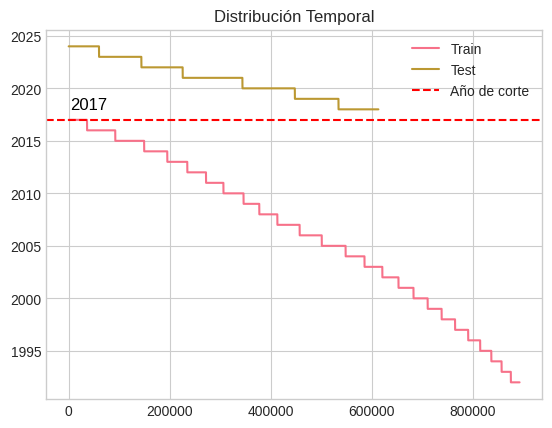

In [8]:
# grafico comparativo de la variable temporal
plt.plot(train['year'], label="Train")
plt.plot(test['year'], label="Test")

## anadir una linea horizonalt en el 2017
plt.axhline(y=2017, color='r', linestyle='--', label='Año de corte')
plt.text(2017, 2018, '2017', color='black', fontsize=12)
plt.legend()
plt.title("Distribución Temporal")
plt.show()

Validamos que nuestro dataset cumpla con las condiciones de tiempo y que no haya fugas de datos entre train y test.


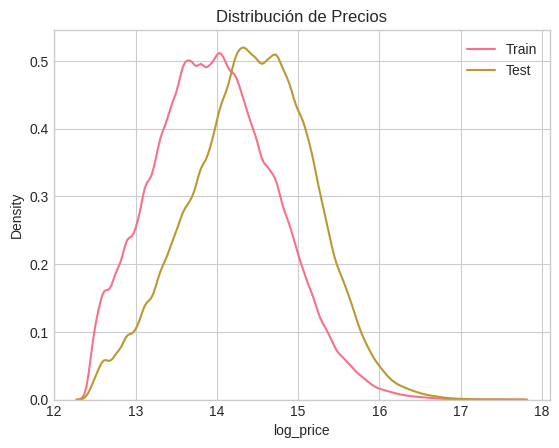

In [9]:
sns.kdeplot(train['log_price'], label='Train')
sns.kdeplot(test['log_price'], label='Test')
plt.title("Distribución de Precios")
plt.legend()
plt.show()


In [10]:
import optuna
import h2o
import pandas as pd
from joblib import load, dump
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from functools import partial
from h2o.estimators import H2OXGBoostEstimator


In [11]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 🔧 FUNCIONES
def load_scaled_data(target=TARGET):
    # 1. Cargar features seleccionados
    selected_features = open(SELECTED_FEATURES_FILE).read().splitlines()

    # 2. Cargar datasets
    train = pd.read_parquet(TRAIN_DATA_FILE)
    test = pd.read_parquet(TEST_DATA_FILE)

    # 3. Separar X e y
    X_train_raw = train[selected_features]
    X_test_raw = test[selected_features]
    y_train = train[target].reset_index(drop=True)
    y_test = test[target].reset_index(drop=True)

    # 4. Escalar X con StandardScaler
    scaler = StandardScaler().fit(X_train_raw)
    X_train = pd.DataFrame(scaler.transform(X_train_raw), columns=selected_features)
    X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=selected_features)
    
    if TARGET in X_train.columns:
        X_train = X_train.drop(columns=[TARGET])
        X_test = X_test.drop(columns=[TARGET])


    return X_train, X_test, y_train, y_test, selected_features, scaler


In [12]:

# 📦 CARGAR DATA

X_train, X_test, y_train, y_test, features, scaler = load_scaled_data(target=TARGET)


In [13]:

train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

train_h2o[TARGET] = train_h2o[TARGET].asnumeric()
test_h2o[TARGET] = test_h2o[TARGET].asnumeric()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial, features, target, train_h2o, test_h2o):
    params = {
        "ntrees": trial.suggest_int("ntrees", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "learn_rate": trial.suggest_float("learn_rate", 0.01, 0.2),
        "col_sample_rate": trial.suggest_float("col_sample_rate", 0.6, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "min_rows": trial.suggest_int("min_rows", 1, 10),
        "backend": "gpu",  
        "seed": 42
    }

    model = H2OXGBoostEstimator(**params)
    model.train(x=features, y=target, training_frame=train_h2o)

    preds = model.predict(test_h2o).as_data_frame().values.ravel()
    true = test_h2o[target].as_data_frame().values.ravel()
    


    rmse = np.sqrt(mean_squared_error(true, preds))
    return rmse

    

# ⛓️ WRAP con partial
objective_fn = partial(
    objective,
    features=features,
    target=TARGET,
    train_h2o=train_h2o,
    test_h2o=test_h2o
)



In [15]:

study_name = "h2o_xgb_gpu_tuning"
storage_url = f"sqlite:///{study_name}.db"

study = optuna.create_study(
    direction="minimize",
    study_name=study_name,
    storage=storage_url,
    load_if_exists=True
)

study.optimize(objective_fn, n_trials=10)

print("✅ Best trial:")
print(study.best_trial.params)

[I 2025-07-13 08:01:31,908] Using an existing study with name 'h2o_xgb_gpu_tuning' instead of creating a new one.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 08:01:52,492] Trial 107 finished with value: 0.006934641779654753 and parameters: {'ntrees': 242, 'max_depth': 11, 'learn_rate': 0.13468034233021328, 'col_sample_rate': 0.9576768098085389, 'subsample': 0.9496349393976814, 'min_rows': 8}. Best is trial 95 with value: 0.006738774742871029.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 08:02:21,076] Trial 108 finished with value: 0.0068617691318513105 and parameters: {'ntrees': 256, 'max_depth': 12, 'learn_rate': 0.19528937071513375, 'col_sample_rate': 0.8227119392132508, 'subsample': 0.9642516681420875, 'min_rows': 7}. Best is trial 95 with value: 0.006738774742871029.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 08:02:49,715] Trial 109 finished with value: 0.006830137832042179 and parameters: {'ntrees': 263, 'max_depth': 12, 'learn_rate': 0.1409211854266705, 'col_sample_rate': 0.8594321214528985, 'subsample': 0.9802786818979028, 'min_rows': 6}. Best is trial 95 with value: 0.006738774742871029.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 08:03:05,699] Trial 110 finished with value: 0.007102840616193737 and parameters: {'ntrees': 197, 'max_depth': 11, 'learn_rate': 0.1466276611632414, 'col_sample_rate': 0.9894029034995739, 'subsample': 0.6698875407261917, 'min_rows': 7}. Best is trial 95 with value: 0.006738774742871029.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 08:03:33,241] Trial 111 finished with value: 0.006900440419045221 and parameters: {'ntrees': 249, 'max_depth': 12, 'learn_rate': 0.18739995465287063, 'col_sample_rate': 0.8311219144062123, 'subsample': 0.9317644431762849, 'min_rows': 8}. Best is trial 95 with value: 0.006738774742871029.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 08:04:02,046] Trial 112 finished with value: 0.0068013165268406145 and parameters: {'ntrees': 267, 'max_depth': 12, 'learn_rate': 0.15477783378773488, 'col_sample_rate': 0.9723758561115272, 'subsample': 0.9931278769803555, 'min_rows': 7}. Best is trial 95 with value: 0.006738774742871029.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 08:04:33,007] Trial 113 finished with value: 0.0068012484818091076 and parameters: {'ntrees': 282, 'max_depth': 12, 'learn_rate': 0.1692095787262909, 'col_sample_rate': 0.9824838133439187, 'subsample': 0.9719648921456089, 'min_rows': 7}. Best is trial 95 with value: 0.006738774742871029.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 08:05:01,591] Trial 114 finished with value: 0.006864269284747228 and parameters: {'ntrees': 259, 'max_depth': 12, 'learn_rate': 0.16417376465752756, 'col_sample_rate': 0.849455852576868, 'subsample': 0.984544086675835, 'min_rows': 7}. Best is trial 95 with value: 0.006738774742871029.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 08:05:32,984] Trial 115 finished with value: 0.0067958975995558455 and parameters: {'ntrees': 273, 'max_depth': 12, 'learn_rate': 0.17997439859540215, 'col_sample_rate': 0.9257916075085196, 'subsample': 0.9602574477151518, 'min_rows': 6}. Best is trial 95 with value: 0.006738774742871029.


xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


[I 2025-07-13 08:05:44,405] Trial 116 finished with value: 0.007358328034949845 and parameters: {'ntrees': 254, 'max_depth': 8, 'learn_rate': 0.1812931993907586, 'col_sample_rate': 0.889748556252827, 'subsample': 0.9571384626364412, 'min_rows': 6}. Best is trial 95 with value: 0.006738774742871029.


✅ Best trial:
{'ntrees': 258, 'max_depth': 12, 'learn_rate': 0.1467301986708811, 'col_sample_rate': 0.9597533372417963, 'subsample': 0.9738806371876458, 'min_rows': 7}


In [20]:
study.best_trial.params

{'ntrees': 258,
 'max_depth': 12,
 'learn_rate': 0.1467301986708811,
 'col_sample_rate': 0.9597533372417963,
 'subsample': 0.9738806371876458,
 'min_rows': 7}

In [22]:
best_params = study.best_trial.params
best_model = H2OXGBoostEstimator(**best_params)
best_model.train(x=features, y=TARGET, training_frame=train_h2o)
best_model_path = best_model.save_mojo(path="models/", force=True)
print(f"📦 Modelo guardado en: {best_model_path}")


xgboost Model Build progress: |

██████████████████████████████████████████████████| (done) 100%
📦 Modelo guardado en: /home/exodia/Documentos/TFBigData/models/XGBoost_model_python_1752411615759_11.zip


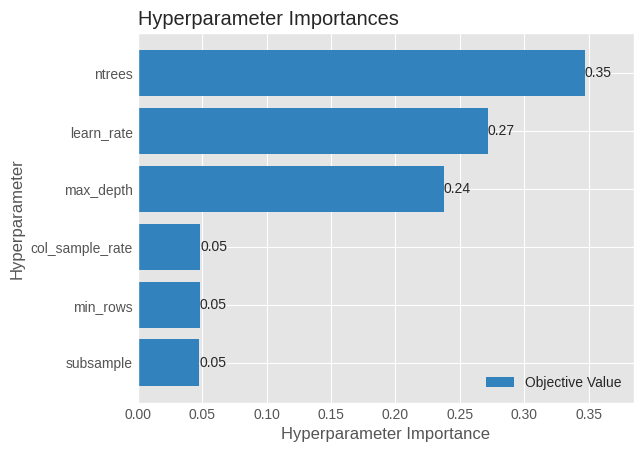

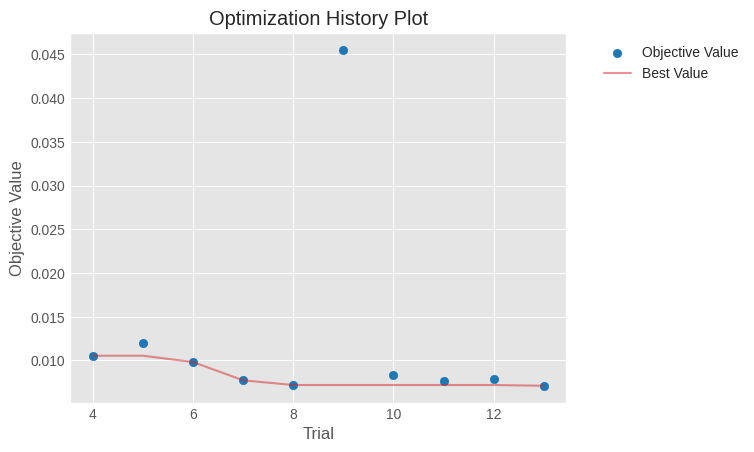

In [ ]:
from optuna.visualization.matplotlib import plot_param_importances, plot_optimization_history
import matplotlib.pyplot as plt

plot_param_importances(study)
plt.show()

plot_optimization_history(study)
plt.show()


In [23]:
evaluation = best_model.model_performance(test_data=test_h2o)
print("RMSE en test:", evaluation.rmse())

RMSE en test: 0.006816049734156307


In [24]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(
    max_runtime_secs=600,           # ⏱️ tiempo total (ajustá según tu disponibilidad)
    seed=42,
    include_algos=["XGBoost"],      # ⚡ Solo modelos con soporte GPU
    sort_metric="RMSE",            # O 'MAE', 'R2', etc.
    keep_cross_validation_predictions=True
)

aml.train(x=features, y=TARGET, training_frame=train_h2o)


AutoML progress: |
08:08:00.402: _train param, Dropping bad and constant columns: [phase_covid_era]

██████████████████████████████████████████████████████████
08:17:13.699: _train param, Dropping bad and constant columns: [phase_covid_era]

█████| (done) 100%

08:18:00.13: _train param, Dropping bad and constant columns: [phase_covid_era]



Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20250713_80800


Model Summary: 
    number_of_trees
--  -----------------
    169

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 1.0647437283662827e-05
RMSE: 0.003263041109710821
MAE: 0.0023775641917050494
RMSLE: 0.00021991499397994675
Mean Residual Deviance: 1.0647437283662827e-05

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 3.7487577780602613e-05
RMSE: 0.006122710002980919
MAE: 0.0035037504462658306
RMSLE: 0.0003979082491166422
Mean Residual Deviance: 3.7487577780602613e-05

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
aic                     nan          0            nan           nan           nan           nan           nan
loglikelihood           nan          0            nan           nan           nan           nan           nan
mae                     0.00350375   5.98976e-05  0.00354447    0.00350143    0.00345237    0.00358082    0.00343966
mean_residual_deviance  3.74876e-05  2.61392e-06  4.17182e-05   3.47194e-05   3.62916e-05   3.77443e-05   3.69644e-05
mse                     3.74876e-05  2.61392e-06  4.17182e-05   3.47194e-05   3.62916e-05   3.77443e-05   3.69644e-05
r2                      0.999933     4.62075e-06  0.999925      0.999938      0.999935      0.999933      0.999934
residual_deviance       3.74876e-05  2.61392e-06  4.17182e-05   3.47194e-05   3.62916e-05   3.77443e-05   3.69644e-05
rmse                    0.0061198    0.000210992  0.00645896    0.00589232    0.00602425    0.00614364    0.00607983
rmsle                   0.000397783  1.11474e-05  0.000414828   0.000385943   0.00039154    0.000401966   0.00039464

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse          training_mae           training_deviance
---  -------------------  ----------------  -----------------  ---------------------  ---------------------  ----------------------
     2025-07-13 08:16:13  8 min 12.613 sec  0.0                13.494937743012462     13.474267105859992     182.11334468778227
     2025-07-13 08:16:13  8 min 13.136 sec  5.0                2.269094519063167      2.2649882869730114     5.148789936442505
     2025-07-13 08:16:13  8 min 13.256 sec  10.0               0.3821751074145991     0.3808328350819629     0.14605781272736035
     2025-07-13 08:16:14  8 min 13.600 sec  15.0               0.0653698989697741     0.06418804251512007    0.004273223691318473
     2025-07-13 08:16:14  8 min 14.495 sec  20.0               0.013552524317792863   0.011673661083833794   0.0001836709153843669
     2025-07-13 08:16:15  8 min 15.533 sec  25.0               0.007271707227724036   0.004979232934751837   5.287772600573399e-05
     2025-07-13 08:16:16  8 min 16.332 sec  30.0               0.006569537396113726   0.004402226464366683   4.3158821598936714e-05
     2025-07-13 08:16:17  8 min 17.053 sec  35.0               0.006202912476377177   0.0042083839512982715  3.847612318959564e-05
     2025-07-13 08:16:18  8 min 17.900 sec  40.0               0.005866293769988322   0.003986895594260588   3.44134025958038e-05
     2025-07-13 08:16:19  8 min 18.768 sec  45.0               0.005631181345385135   0.003851485420667296   3.171020334461354e-05
---  ---                  ---               ---                ---                    ---                    ---
     2025-07-13 08:16:43  8 min 43.443 sec  125.0              0.0037808290780328093  0.002712128698189955   1.4294668517298421e-05
     2025-07-13 08:16:46  8 min 45.848 sec  130.0              0.0037180006103060934  0.002675889828040687   1.3823528538236482e-05
     2025-07-13 08:16:48  8 min 48.342 sec  135.0              0.0036392640805968796  0.002622670603195260

In [25]:
# Evaluar en test_h2o
perf_automl = aml.leader.model_performance(test_h2o)
print("🔍 AutoML RMSE:", perf_automl.rmse())

# Comparar con Optuna-tuneado
perf_optuna = best_model.model_performance(test_h2o)
print("🎯 Optuna RMSE:", perf_optuna.rmse())



🔍 AutoML RMSE: 0.007924705030962624
🎯 Optuna RMSE: 0.006816049734156307


In [26]:
# ==================================================
# 📊 EVALUACIÓN COMPRENSIVA DE MODELOS
# ==================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def calculate_mape(y_true, y_pred):
    """Calcula MAPE evitando división por cero"""
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_model(model, test_h2o, model_name):
    """Evalúa un modelo H2O y retorna métricas"""
    # Predicciones
    preds = model.predict(test_h2o).as_data_frame().values.ravel()
    true = test_h2o[TARGET].as_data_frame().values.ravel()
    
    # Métricas
    rmse = np.sqrt(mean_squared_error(true, preds))
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    mape = calculate_mape(true, preds)
    
    return {
        'Modelo': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape,
        'Predicciones': preds,
        'Reales': true
    }

# Evaluar ambos modelos
results = []
results.append(evaluate_model(best_model, test_h2o, "XGBoost Optuna"))
results.append(evaluate_model(aml.leader, test_h2o, "AutoML Leader"))

print("✅ Evaluación completada")

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
✅ Evaluación completada


🏆 COMPARACIÓN DE MODELOS:
        Modelo   RMSE    MAE     R²  MAPE (%)
XGBoost Optuna 0.0068 0.0037 0.9999    0.0253
 AutoML Leader 0.0079 0.0043 0.9999    0.0293

🥇 Mejor modelo: XGBoost Optuna


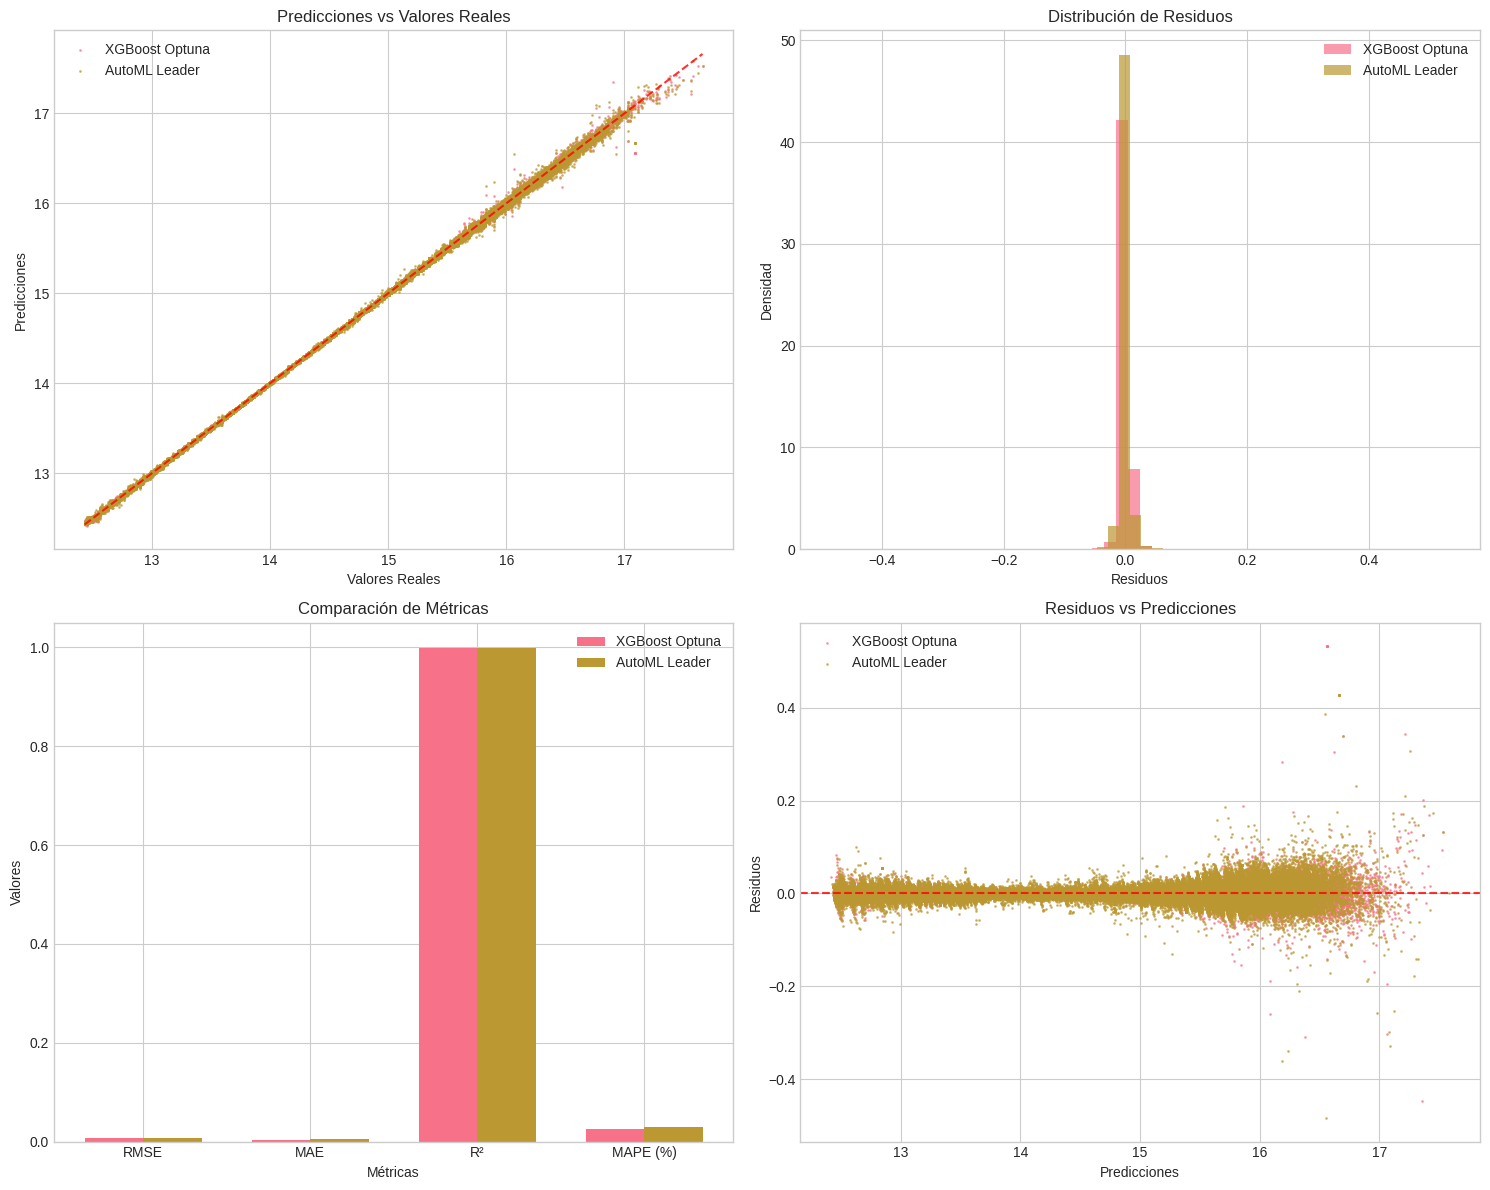

In [27]:
# ==================================================
# 📈 TABLA COMPARATIVA Y VISUALIZACIONES
# ==================================================

# Crear tabla comparativa
comparison_df = pd.DataFrame(results)[['Modelo', 'RMSE', 'MAE', 'R²', 'MAPE (%)']]
comparison_df = comparison_df.round(4)

print("🏆 COMPARACIÓN DE MODELOS:")
print("=" * 50)
print(comparison_df.to_string(index=False))

# Identificar mejor modelo
best_idx = comparison_df['RMSE'].idxmin()
best_model_name = comparison_df.iloc[best_idx]['Modelo']
print(f"\n🥇 Mejor modelo: {best_model_name}")

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Predicciones vs Reales
for i, result in enumerate(results):
    axes[0, 0].scatter(result['Reales'], result['Predicciones'], 
                      alpha=0.6, label=result['Modelo'], s=1)
axes[0, 0].plot([min(results[0]['Reales']), max(results[0]['Reales'])], 
                [min(results[0]['Reales']), max(results[0]['Reales'])], 'r--', alpha=0.8)
axes[0, 0].set_xlabel('Valores Reales')
axes[0, 0].set_ylabel('Predicciones')
axes[0, 0].set_title('Predicciones vs Valores Reales')
axes[0, 0].legend()

# 2. Distribución de Residuos
for i, result in enumerate(results):
    residuals = result['Reales'] - result['Predicciones']
    axes[0, 1].hist(residuals, bins=50, alpha=0.7, label=result['Modelo'], density=True)
axes[0, 1].set_xlabel('Residuos')
axes[0, 1].set_ylabel('Densidad')
axes[0, 1].set_title('Distribución de Residuos')
axes[0, 1].legend()

# 3. Métricas comparativas
metrics = ['RMSE', 'MAE', 'R²', 'MAPE (%)']
x_pos = np.arange(len(metrics))
width = 0.35

for i, result in enumerate(results):
    values = [comparison_df.iloc[i]['RMSE'], comparison_df.iloc[i]['MAE'], 
              comparison_df.iloc[i]['R²'], comparison_df.iloc[i]['MAPE (%)']]
    axes[1, 0].bar(x_pos + i*width, values, width, label=result['Modelo'])

axes[1, 0].set_xlabel('Métricas')
axes[1, 0].set_ylabel('Valores')
axes[1, 0].set_title('Comparación de Métricas')
axes[1, 0].set_xticks(x_pos + width/2)
axes[1, 0].set_xticklabels(metrics)
axes[1, 0].legend()

# 4. Residuos vs Predicciones
for i, result in enumerate(results):
    residuals = result['Reales'] - result['Predicciones']
    axes[1, 1].scatter(result['Predicciones'], residuals, 
                      alpha=0.6, label=result['Modelo'], s=1)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 1].set_xlabel('Predicciones')
axes[1, 1].set_ylabel('Residuos')
axes[1, 1].set_title('Residuos vs Predicciones')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

🔍 IMPORTANCIA DE VARIABLES:
                   variable  relative_importance  scaled_importance  percentage
price_deviation_from_median         1.421720e+06           1.000000    0.809786
      price_category_Medium         1.290225e+05           0.090751    0.073489
     price_category_Premium         1.131842e+05           0.079611    0.064468
          region_price_mean         5.945020e+04           0.041816    0.033862
              price_per_sqm         1.689015e+04           0.011880    0.009620
        price_category_High         8.901675e+03           0.006261    0.005070
                        sqm         3.352908e+03           0.002358    0.001910
      region_target_encoded         1.698639e+03           0.001195    0.000968
               sqm_x_region         1.294435e+03           0.000910    0.000737
     price_per_sqm_x_region         8.092607e+01           0.000057    0.000046


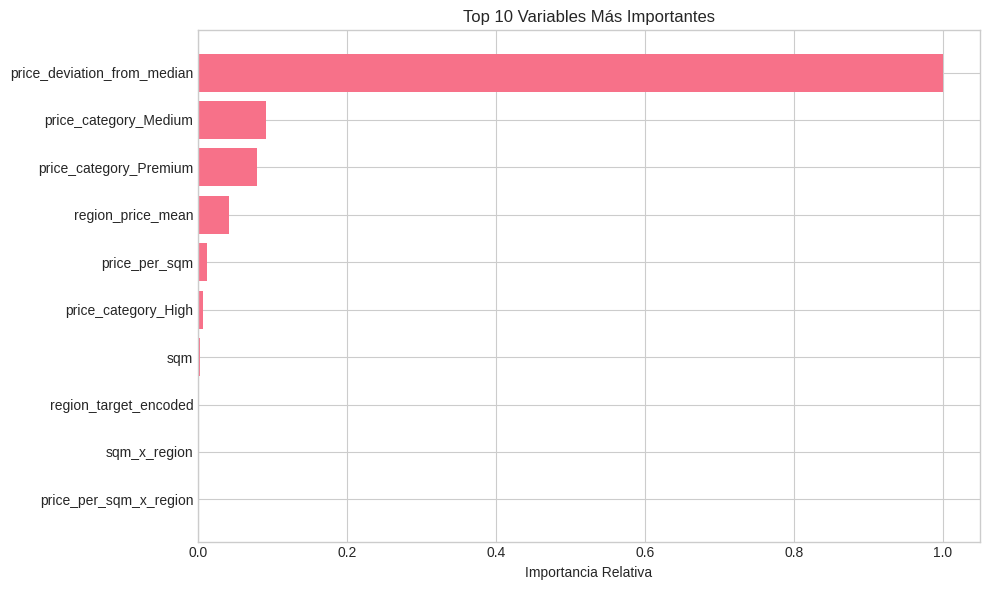


💾 Resultados guardados en: results/model_evaluation_summary.json
📊 Muestras evaluadas: 613,479
✅ Evaluación completa finalizada


In [28]:
# ==================================================
# 🎯 ANÁLISIS DE IMPORTANCIA Y RESUMEN FINAL
# ==================================================

# Feature Importance del mejor modelo
print("🔍 IMPORTANCIA DE VARIABLES:")
print("=" * 40)

# Obtener importancia de variables
varimp = best_model.varimp(use_pandas=True)
top_features = varimp.head(10)

print(top_features.to_string(index=False))

# Visualizar importancia
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['scaled_importance'])
plt.yticks(range(len(top_features)), top_features['variable'])
plt.xlabel('Importancia Relativa')
plt.title('Top 10 Variables Más Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Guardar resultados
results_summary = {
    'best_model': best_model_name,
    'metrics': comparison_df.to_dict('records'),
    'feature_importance': top_features.to_dict('records'),
    'total_test_samples': len(results[0]['Reales'])
}

# Guardar en archivo
import json
with open('results/model_evaluation_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\n💾 Resultados guardados en: results/model_evaluation_summary.json")
print(f"📊 Muestras evaluadas: {results_summary['total_test_samples']:,}")
print("✅ Evaluación completa finalizada")